In [3]:
import os
import random
from time import time
from glob import glob
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm
from collections import Counter

from matplotlib import pyplot as plt
%matplotlib inline

import cv2

from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import fbeta_score, confusion_matrix

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms as T, models
from torch.optim import Adam
from torch.optim.lr_scheduler import StepLR
import albumentations as albu


In [4]:
if torch.backends.mps.is_available():
    device = torch.device("mps")
    print(f"device: {device}")
    x = torch.ones(1, device=device)
    print (x)
else:
    print ("MPS device not found.")

device: mps
tensor([1.], device='mps:0')


In [6]:
path = '../data/'
path_train_jpg = os.path.join(path, 'images') 
path_classes = os.path.join(path, 'train_classes.csv')
path_test_jpg = os.path.join(path, 'test-jpg')
print(
    f'train jpg files: {len(os.listdir(path_train_jpg))}, '
    f'test jpg files: {len(os.listdir(path_test_jpg))}'
)

train jpg files: 40479, test jpg files: 40669


In [7]:
path_train_jpg

'../data/images'

In [8]:
df_classes = pd.read_csv(path_classes)
print(df_classes.shape)
df_classes.head(5)

(40479, 2)


,image_name,tags
0,train_0,haze primary
1,train_1,agriculture clear primary water
2,train_2,clear primary
3,train_3,clear primary
4,train_4,agriculture clear habitation primary road


In [9]:
df_classes['tags_list'] = df_classes['tags'].str.split(' ')
df_classes['tags_count'] = df_classes['tags_list'].apply(lambda x: len(x))

In [10]:
df_classes['tags_count'].value_counts()

tags_count
2    19176
3     7192
4     7171
5     3700
1     2091
6      996
7      127
8       24
9        2
Name: count, dtype: int64

In [13]:
row_tags = df_classes.tags_list.values
tags_list = [cl for row in row_tags for cl in row]
tags_counter = Counter(tags_list)
classes = list(set(tags_list))
classes

['selective_logging',
 'conventional_mine',
 'cloudy',
 'clear',
 'cultivation',
 'partly_cloudy',
 'blooming',
 'primary',
 'haze',
 'slash_burn',
 'road',
 'water',
 'bare_ground',
 'artisinal_mine',
 'blow_down',
 'habitation',
 'agriculture']

In [14]:
len(classes)

17

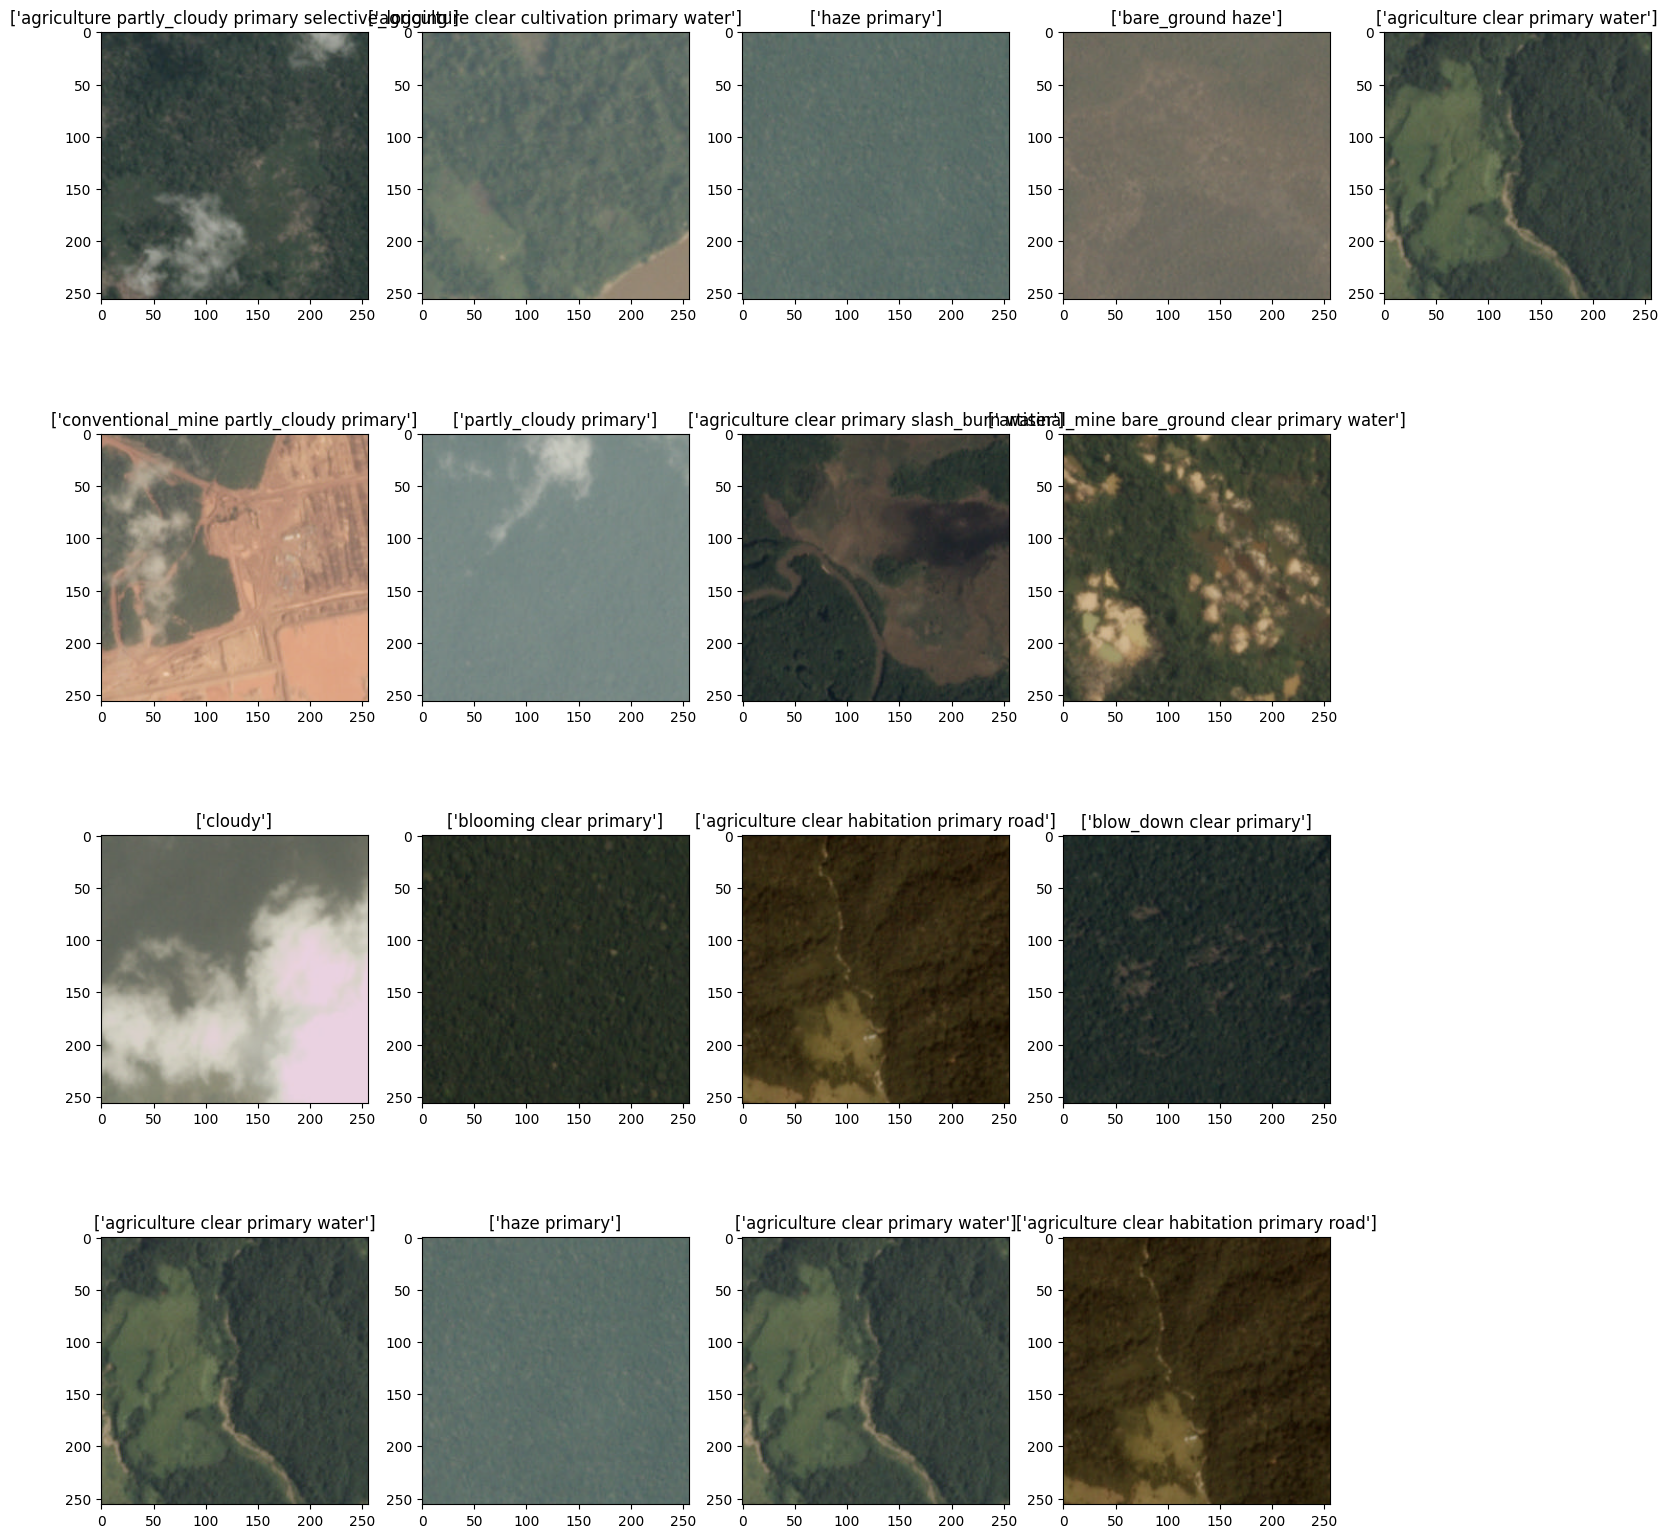

In [18]:
N_tags = len(classes)
fig, axes = plt.subplots(4, (N_tags//4)+1, figsize=(20, 20))
for idx, tag in enumerate(classes):
    filename = df_classes.loc[df_classes.tags.str.contains(tag)].image_name.values[0]
    img = cv2.imread(os.path.join(path_train_jpg, filename+".jpg"))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    idx_col = idx // 4
    idx_row = idx % 4
    axes[idx_row][idx_col].set_title(df_classes.loc[df_classes['image_name'] == filename, 'tags'].values)
    axes[idx_row][idx_col].imshow(img)
axes[1][-1].remove()
axes[2][-1].remove()
axes[3][-1].remove()

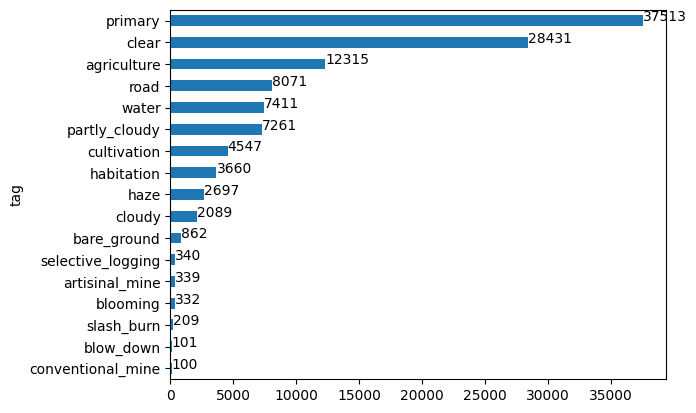

In [12]:
df_tags = pd.DataFrame(
    {"tag": tags_counter.keys(), "total_num": tags_counter.values()}
).sort_values("total_num")
ax = df_tags.plot(kind='barh', x='tag',  y='total_num', legend=None,)
for index, value in enumerate(df_tags['total_num']):
    plt.text(value, index, str(value))
plt.show()

In [44]:
RARE_CLASSES = [
    "bare_ground", "selective_logging", "artisinal_mine", "blooming", "slash_burn", "blow_down", "conventional_mine"
]

In [57]:
file_names = os.listdir(path_train_jpg)
file_names = [name.replace('.jpg', '') for name in file_names]

In [60]:
len(df_classes["image_name"].values)

40479

In [61]:
len(file_names)

40479

In [59]:
diff1 = list(set(df_classes["image_name"].values) - set(file_names))
diff1

[]

In [68]:
df_train = df_classes.drop(columns=['classes', 'tags_count', 'tags'])

In [70]:
df_train

,image_name,tags_list
0,train_0,"[haze, primary]"
1,train_1,"[agriculture, clear, primary, water]"
2,train_2,"[clear, primary]"
3,train_3,"[clear, primary]"
4,train_4,"[agriculture, clear, habitation, primary, road]"
...,...,...
40474,train_40474,"[clear, primary]"
40475,train_40475,[cloudy]
40476,train_40476,"[agriculture, clear, primary]"
40477,train_40477,"[agriculture, clear, primary, road]"


In [84]:
df_train['image_name'] = df_train['image_name'].apply(lambda x: x.replace('.jpg', ''))

In [72]:
##One hot encoding is performed on the labels in train classes
for tag in classes:
    df_train[tag] = df_train['tags_list'].apply(lambda x: 1 if tag in x else 0)


,image_name,tags_list,road,cultivation,agriculture,haze,clear,habitation,bare_ground,blooming,partly_cloudy,selective_logging,blow_down,primary,slash_burn,artisinal_mine,water,conventional_mine,cloudy
0,train_0.jpg,"[haze, primary]",0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0
1,train_1.jpg,"[agriculture, clear, primary, water]",0,0,1,0,1,0,0,0,0,0,0,1,0,0,1,0,0
2,train_2.jpg,"[clear, primary]",0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0
3,train_3.jpg,"[clear, primary]",0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0
4,train_4.jpg,"[agriculture, clear, habitation, primary, road]",1,0,1,0,1,1,0,0,0,0,0,1,0,0,0,0,0


In [86]:
df_train = df_train.rename(columns={'image_name': 'Id'})

In [88]:
df_train.to_csv(os.path.join(path, 'train.csv'), index=False)

In [81]:
images = cv2.imread(os.path.join(path_train_jpg, df_train['Id'].iloc[468]))
print("Size of an image: ", images.shape)

Size of an image:  (256, 256, 3)
